In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
sns.set_style("whitegrid")

Our next task is to get the "opening" cutoff week for each movie based on the threshold from the box office data

# Compute the Opening Week Cutoff and Multiplier for each movie

In [2]:
boxOffice = pickle.load( open( "LeapReallyCleanedBoxofficeData.p", "rb" ) )
multiplierDataFrame = pd.DataFrame(columns=('title', 'Opening Week', 'Opening Week Number', 'Multiplier'))
i=0
threshold = 0.6
for title in boxOffice:
    cleanTitle = title.split(' (')[0] # Remove Year Tag
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    startingWeek = boxOffice[title][boxOffice[title].Theaters>=threshold*widestWeek].Week.min()
    # weekCutoffs[cleanTitle] = pd.to_datetime(boxOffice[title].at[startingWeek, 'Date'])
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
    multiplierDataFrame.loc[i] = [cleanTitle, pd.to_datetime(boxOffice[title].at[startingWeek, 'Date']), startingWeek, multiplier]
    i+=1
multiplierDataFrame

,title,Opening Week,Opening Week Number,Multiplier
0,Alien,1979-06-22,5,2.416036
1,Raging Bull,1980-12-19,6,1.000000
2,Star Wars: Episode V - The Empire Strikes Back,1980-06-20,6,1.590517
3,Modern Problems,1981-12-25,1,3.600396
4,On Golden Pond,1982-02-12,11,3.246197
...,...,...,...,...
6145,Companion,2025-01-31,1,1.669133
6146,Green and Gold,2025-01-31,1,1.561074
6147,Den of Thieves: Pantera,2025-01-10,1,1.839845
6148,Presence,2025-01-24,1,1.518704


In [3]:
# read in review and movie data into data frames
dfs = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_scale.csv', index_col=False)
dfm = pd.read_csv('./cleandata/rotten_tomatoes_movies_clean.csv', index_col=False)

rottenMovies = dfm.filter(['id', 'title']) # One line per movie with id, title, and "Release Date"
rottenReviews = dfs.filter(['id', 'creationDate', 'isTopCritic', 'originalScore']) # One line per review with normalized score, etc.
rottenReviews['binaryScore'] = [0 if sS == "NEGATIVE" else 1 for sS in dfs['scoreSentiment']] # Convert sentiment to numerical value
movie_ids_winfo = pd.unique(rottenMovies['id']).tolist() # unique list of movie ids from movie list

rottenReviewsWithTitles = rottenReviews.merge(rottenMovies, how='inner', on='id')
rottenReviewsWithMultipliers = rottenReviewsWithTitles.merge(multiplierDataFrame, how='inner', on='title')
rottenReviewsWithMultipliers['creationDate'] = pd.to_datetime(rottenReviewsWithMultipliers['creationDate'])
rottenReviewsWithMultipliers.head()

,id,creationDate,isTopCritic,originalScore,binaryScore,title,Opening Week,Opening Week Number,Multiplier
0,addicted_2014,2019-09-06,False,0.200,0,Addicted,2014-10-10,1,1.855915
1,addicted_2014,2015-01-09,False,0.000,0,Addicted,2014-10-10,1,1.855915
2,addicted_2014,2014-10-16,True,0.425,0,Addicted,2014-10-10,1,1.855915
3,addicted_2014,2014-10-11,True,0.375,0,Addicted,2014-10-10,1,1.855915
4,addicted_2014,2014-10-10,True,0.300,0,Addicted,2014-10-10,1,1.855915


# Computing Early Reviews and Looking at their distributions

To get a sense for how critics score movies numerically, let's look at distribution the average score for each movie to see what a baseline is to help define what "neutral" reviews might look like and to use that to help define out null hypothesis.

In [4]:
earlyReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']]
earlyTopReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[(rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']) \
 & (rottenReviewsWithMultipliers.isTopCritic)]

avgEarlyReviews = earlyReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

avgEarlyTopReviews = earlyTopReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyTopReviewsInfo = avgEarlyTopReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

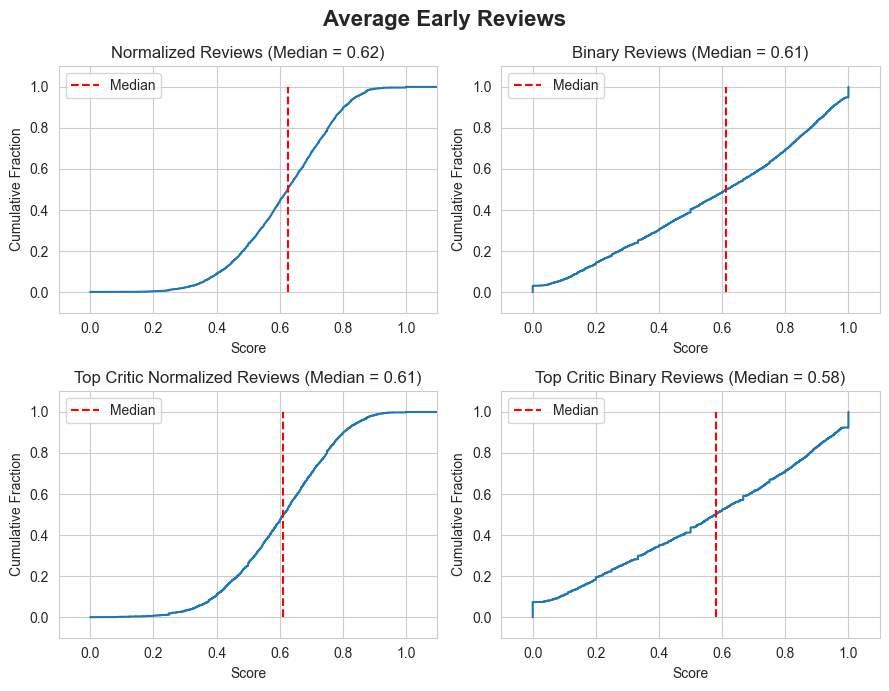

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7), layout='tight')
fig.suptitle('Average Early Reviews', fontweight='bold', fontsize=16)
ax[0,0].ecdf(avgEarlyReviews.originalScore)
ax[0,0].set_title('Normalized Reviews (Median = %.2f)' % avgEarlyReviews.originalScore.median())
ax[0,0].vlines(avgEarlyReviews.originalScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[0,1].ecdf(avgEarlyReviews.binaryScore)
ax[0,1].set_title('Binary Reviews (Median = %.2f)' % avgEarlyReviews.binaryScore.median())
ax[0,1].vlines(avgEarlyReviews.binaryScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[1,0].ecdf(avgEarlyTopReviews.originalScore)
ax[1,0].set_title('Top Critic Normalized Reviews (Median = %.2f)' % avgEarlyTopReviews.originalScore.median())
ax[1,0].vlines(avgEarlyTopReviews.originalScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[1,1].ecdf(avgEarlyTopReviews.binaryScore)
ax[1,1].set_title('Top Critic Binary Reviews (Median = %.2f)' % avgEarlyTopReviews.binaryScore.median())
ax[1,1].vlines(avgEarlyTopReviews.binaryScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Score')
        ax[i,j].set_ylabel('Cumulative Fraction')
        ax[i,j].set_xlim([-0.1, 1.1])
        ax[i,j].set_ylim([-0.1, 1.1])
        ax[i,j].legend()

As these plots show, reviews do tend to skew slightly above 0.5 and the median review across all these metrics is close to 0.6. It would also seem that top critic rating patterns follow pretty closely with the rest of the critics. However it is interesting to note that top critics seem to be slightly more likely to be unanimous as to whether a movie is rotten or fresh as judged by the vertical jumps in the binary review CDFs at 0 and 1. For the purposes of creating subsets of movies grouped by early reviews for hypothesis testing, I will group movies between 0.5 and 0.7 as "neutral reviews" since this captures about the middle 60% for the various review types. That leaves us with two other groups for bad and great reviews.

# Multiplier Distributions by Early Reviews

So what happens when we separately consider movies that have good, neutral, and bad early reviews. Does this seem to affect (or at least correlate) with a movie's multiplier or how well a movie plays after it's opening week(s)? To qualitatively analyze this I have separated movies into groups of bad, neutral, and good reviews based on cutoffs chosen from looking at the CDF plots. As discussed above, I think these cutoffs will fit well across the different review and scoring types. They are as follows. 

$$
\text{Bad Reviews}        = \{0<\text{Average Review}<0.5\}\\
\text{Neutral Reviews}        = \{0.5<\text{Average Review}<0.7\}\\
\text{Good Reviews}        = \{0.7<\text{Average Review}<1\}
$$

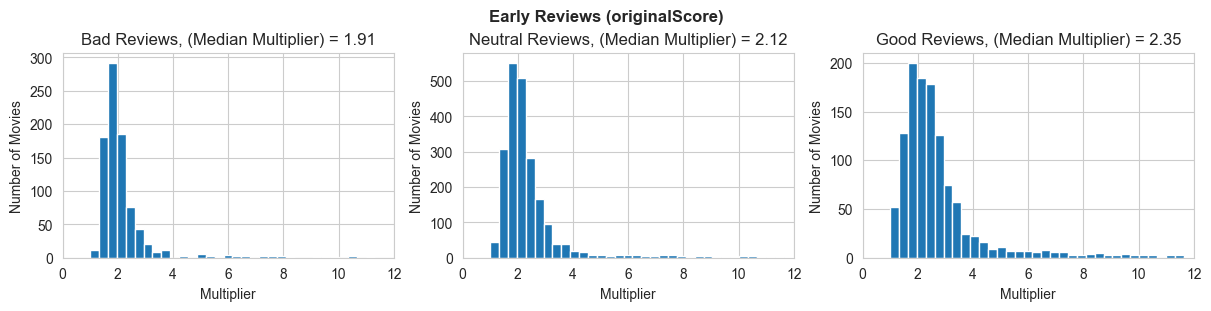

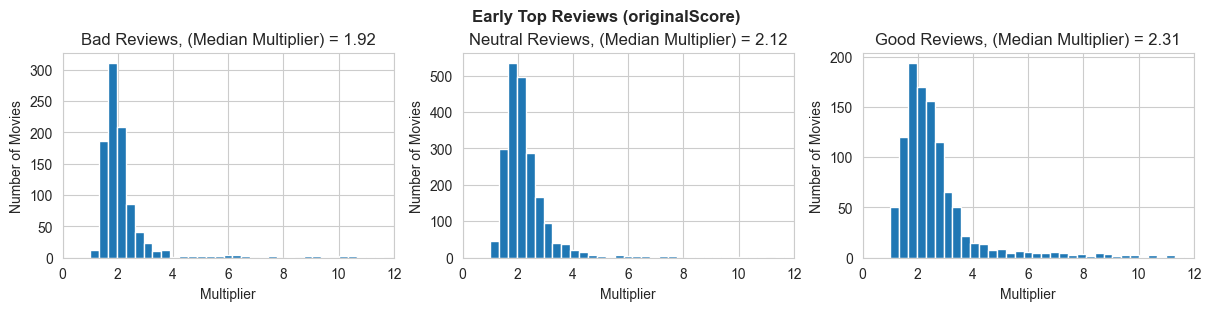

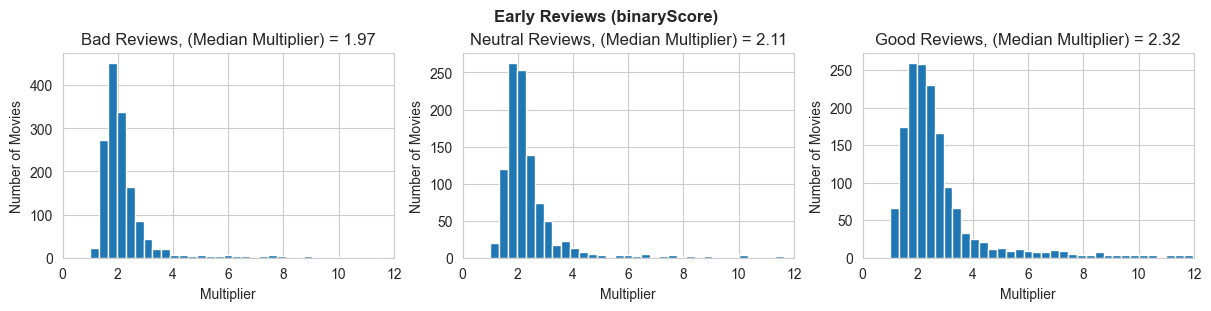

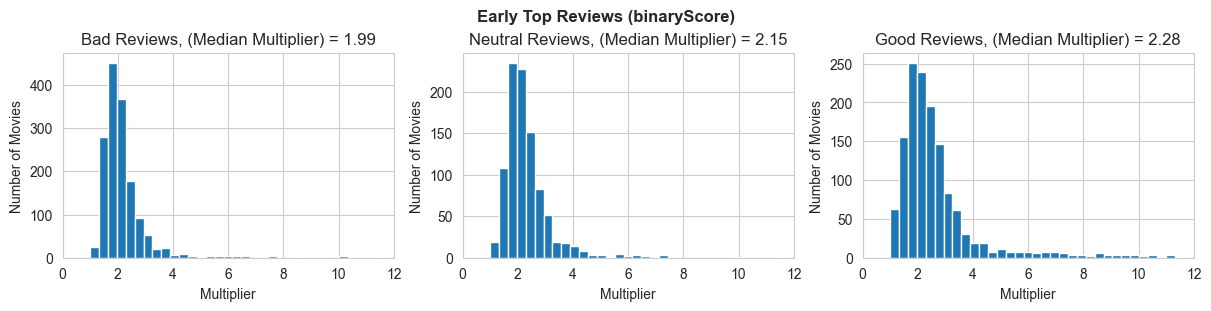

In [6]:
avgEarlyReviews = earlyReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

reviewTypes = [avgEarlyReviews, avgEarlyTopReviews]
typeNames = ['Early Reviews', 'Early Top Reviews']
scoreTypes = ['originalScore', 'binaryScore']

for scoreType in scoreTypes:
    j=0
    for reviewType in reviewTypes:
        fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
        ax[0].set_title('Bad Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0, 0.5)].Multiplier.median())
        ax[1].set_title('Neutral Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0.5, 0.7)].Multiplier.median())
        ax[2].set_title('Good Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0.7, 1)].Multiplier.median())
        ax[0].hist(reviewType.loc[reviewType[scoreType].between(0, 0.5)].Multiplier, bins=np.linspace(1, 20, 60))
        ax[1].hist(reviewType.loc[reviewType[scoreType].between(0.4, 0.7)].Multiplier, bins=np.linspace(1, 20, 60))
        ax[2].hist(reviewType.loc[reviewType[scoreType].between(0.7, 1)].Multiplier, bins=np.linspace(1, 20, 60))
        for i in range(3):
            ax[i].set_xlim([0, 12])
            ax[i].set_xlabel('Multiplier')
            ax[i].set_ylabel('Number of Movies')
        fig.suptitle(typeNames[j] +' ('+scoreType+')', weight='bold')
        j+= 1

As we had hoped, there is a clear shift in the distribution of the multiplier showing that movies with good reviews tend to play better over time compared to average reviews and that those with bad reviews fair worse. And this shift seems quite consistent looking at the binary classified scores as well as the normalized scale score of the critics. Particularly notable are the high multiplier outliers which tend to be found in the good review section. Next let's quantify this shift in the distribution with some hypothesis testing.

# Hypothesis Testing
We would like to compute some p-values comparing the multiplier distributions for the sets of movies with good and bad early reviews to the distribution from movies with neutral reviews. One obvious challenge this data presents is that it is clearly not normally distributed. Of particular concern is the fact that the multiplier cannot take on a value below 1 (which corresponds to a movie which made all of its money during its opening). Given the large sample sizes of these distributions (thousands of movies), we might consider using a Student's t-test despite the non-normality of the multiplier distribution. However to avoid problems which may occur as we begin looking at smaller sections of the data, we have opted to use a non-parametric test, particularly the Mann–Whitney U test to asses the statistical significance of these shifts in multiplier values.

In [8]:
from scipy.stats import mannwhitneyu
badReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0, 0.5)]
neutralReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.5, 0.7)]
goodReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.7, 1)]

data = {
    'Early Reviews': ['Bad', 'Good'],
    'Median Multiplier': [badReviews.Multiplier.median(), goodReviews.Multiplier.median()],
    'Mann-Whitney p-value': [mannwhitneyu(badReviews.Multiplier, neutralReviews.Multiplier).pvalue,
                          mannwhitneyu(goodReviews.Multiplier, neutralReviews.Multiplier).pvalue]
    
}
pd.DataFrame(data)

,Early Reviews,Median Multiplier,Mann-Whitney p-value
0,Bad,1.911224,1.128664e-19
1,Good,2.353561,2.233738e-08


Both good and bad reviews have a statistically significant difference in multiplier distributions as suggested by the low p-values. In other words, the difference in good and bad review multiplier distributions as compared to neutral reviews is highly unlikely to be due to sample variation at this sample size and we should reject the null hypothesis that good and bad review multipliers were drawn from the same underlying distribution as those with neutral reviews. Not only are these differences statistically significant, but we argue they are practically significant. Since,

$$ 
\frac{\text{Total Gross}}{\text{Opening}} = \text{Multiplier}
\\
\text{Total Gross} = (\text{Multiplier})(\text{Opening})
$$

A 0.4 difference in the multiplier corresponds to a 40% difference in total gross given the same opening. Which for most of the movies considered corresponds to millions of dollars. 
